In [3]:
from __future__ import division
import math

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [4]:
import matplotlib as mpl
mpl.rc('savefig', dpi=300)

In [5]:
city_width = 16 # blocks
city_length = 100 # blocks
city_area = city_width * city_length # blocks^2
drone_speed = 10 # meters / second
cell_dist = 250 # meters
time_between_recharging = 18000 # seconds
charging_time = 500 # seconds
medium_priority_freq = 1 / 900 # 1 / second
high_priority_freq = 1 / 300 # 1 / second
low_priority_freq = 1 / 1200 # 1 / second
repair_probability = 0.001
time_penalty_for_turn = 500 # seconds

##Part 1

In [6]:
n_min = lambda freq, region_area: math.ceil(freq * cell_dist * region_area * (time_between_recharging + charging_time) / (drone_speed * time_between_recharging))
print n_min(medium_priority_freq, city_area)

46.0


In [7]:
step_size = 1 # seconds
num_steps = 60 * 60 * 6 # 6 hours

In [8]:
def simulate_surveillance(num_drones, region_area, repair_probability=0, uniform_init=True, rand_dirs=False):
    step_length = drone_speed * step_size
    path_length = int(math.ceil(region_area * cell_dist / step_length))
    times_since_last_observation = np.zeros((num_steps, path_length))
    
    if uniform_init:
        drone_positions = np.arange(0, path_length, path_length / num_drones, dtype=int)
    else:
        drone_positions = np.random.choice(range(path_length), size=num_drones, replace=True)    
    
    if rand_dirs:
        drone_dirs = 2 * (np.random.random(num_drones) < 0.5) - 1
    else:
        drone_dirs = np.ones(num_drones)
                
    for t in xrange(num_steps):
        not_in_repair = np.random.random(num_drones) >= repair_probability
        drone_positions = (drone_positions + not_in_repair * drone_dirs) % path_length
        times_since_last_observation[t, :] = times_since_last_observation[t-1, :] + step_size
        times_since_last_observation[t, drone_positions[not_in_repair].astype(int)] = 0
        
    return times_since_last_observation

In [9]:
times_since_last_observation = simulate_surveillance(n_min(medium_priority_freq, city_area), city_area)
assert (times_since_last_observation < 1 / medium_priority_freq).all()
print "Tests passed"

Tests passed


/home/chris/.anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [10]:
step_size = 10 # seconds

##Part 2

Charge time penalty for making turns

In [11]:
assert time_between_recharging - 2 * time_penalty_for_turn * min(city_width, city_length) > 0

In [12]:
n_min_with_charge_penalty = lambda freq, region_width, region_length, time_penalty_for_turn: math.ceil(freq * cell_dist * region_width * region_length * (time_between_recharging - 2 * time_penalty_for_turn * min(region_width, region_length) + charging_time) / (drone_speed * (time_between_recharging - 2 * time_penalty_for_turn * min(region_width, region_length))))
print n_min_with_charge_penalty(medium_priority_freq, city_width, city_length, time_penalty_for_turn)

56.0


In [13]:
xs = range(time_between_recharging // (2 * min(city_width, city_length)))
ys = [n_min_with_charge_penalty(medium_priority_freq, city_width, city_length, x) for x in xs]

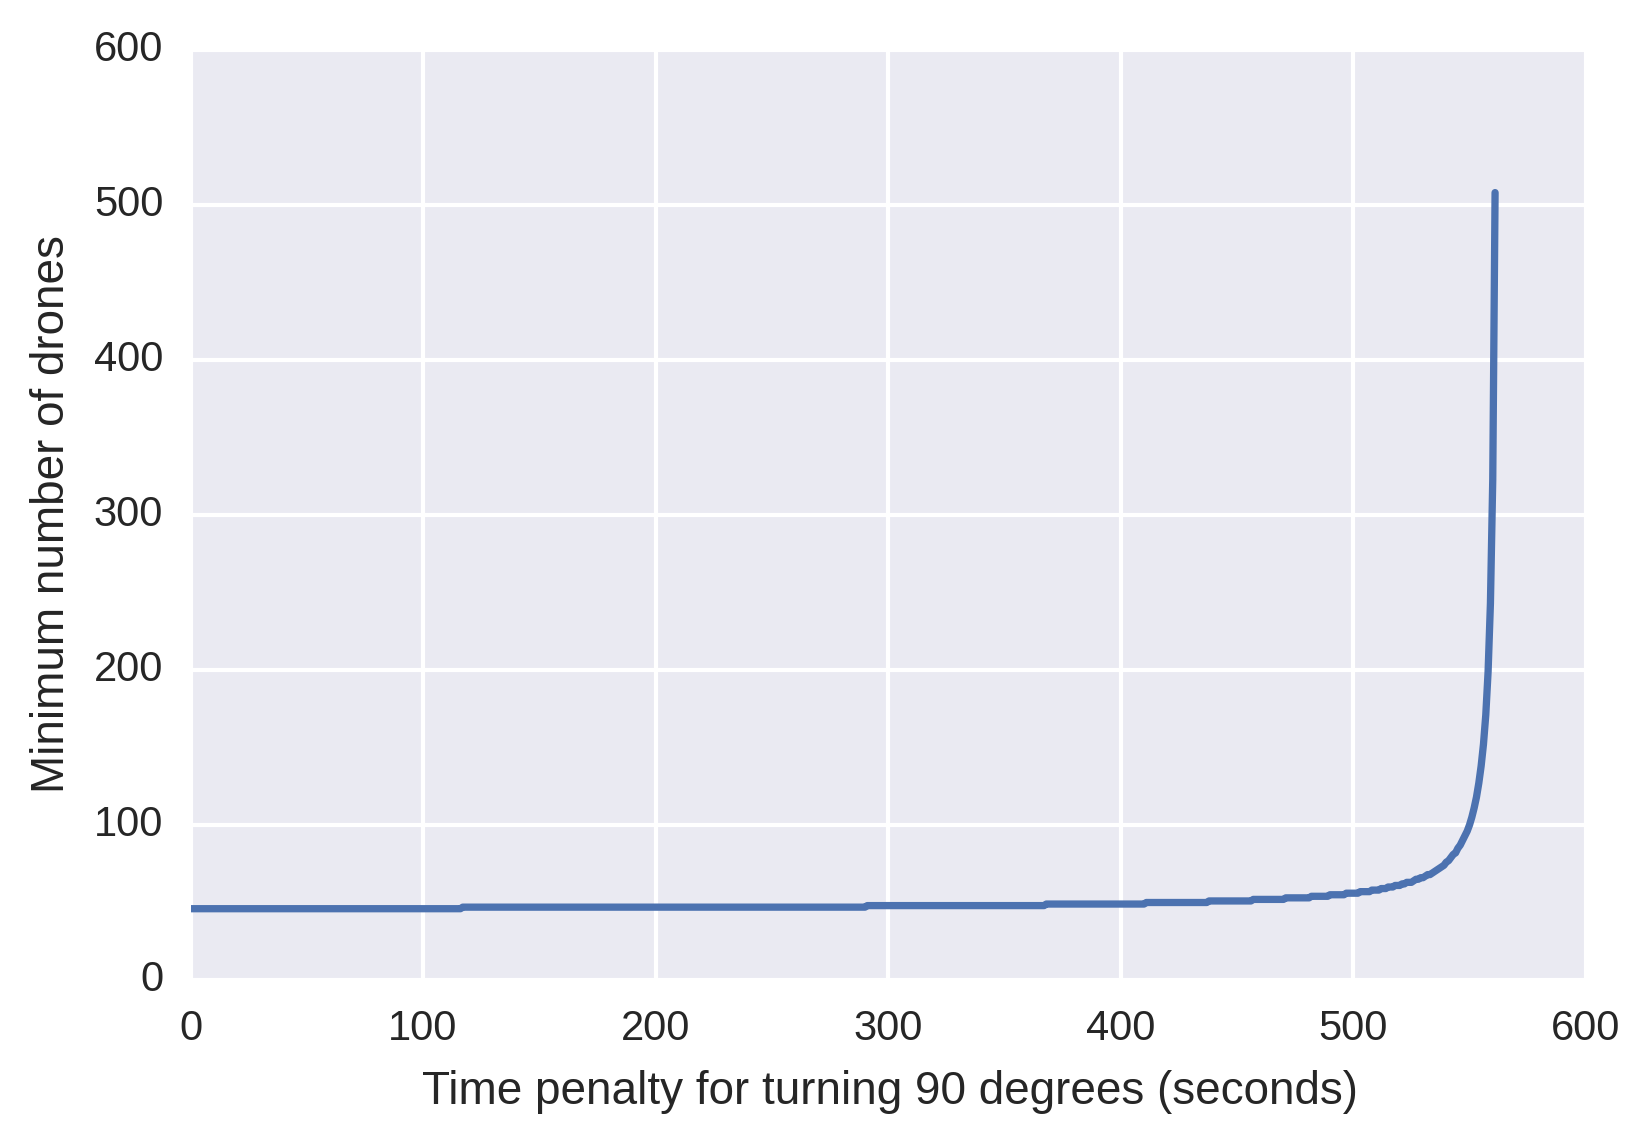

In [14]:
plt.xlabel('Time penalty for turning 90 degrees (seconds)')
plt.ylabel('Minimum number of drones')
plt.plot(xs, ys)
plt.savefig('part2a.pdf', dpi=300)
plt.show()

Consider repairs

In [15]:
def prob_freq_constraint_broken(num_drones, repair_probability):
    times_since_last_observation = simulate_surveillance(num_drones, city_area, repair_probability=repair_probability, uniform_init=False)
    return np.mean(times_since_last_observation > 1 / medium_priority_freq)

In [16]:
xs = np.arange(10, 1000, 10)
repair_probabilities = [0.1, 0.5, 0.75]
ys = [[prob_freq_constraint_broken(x, rp) for x in xs] for rp in repair_probabilities]

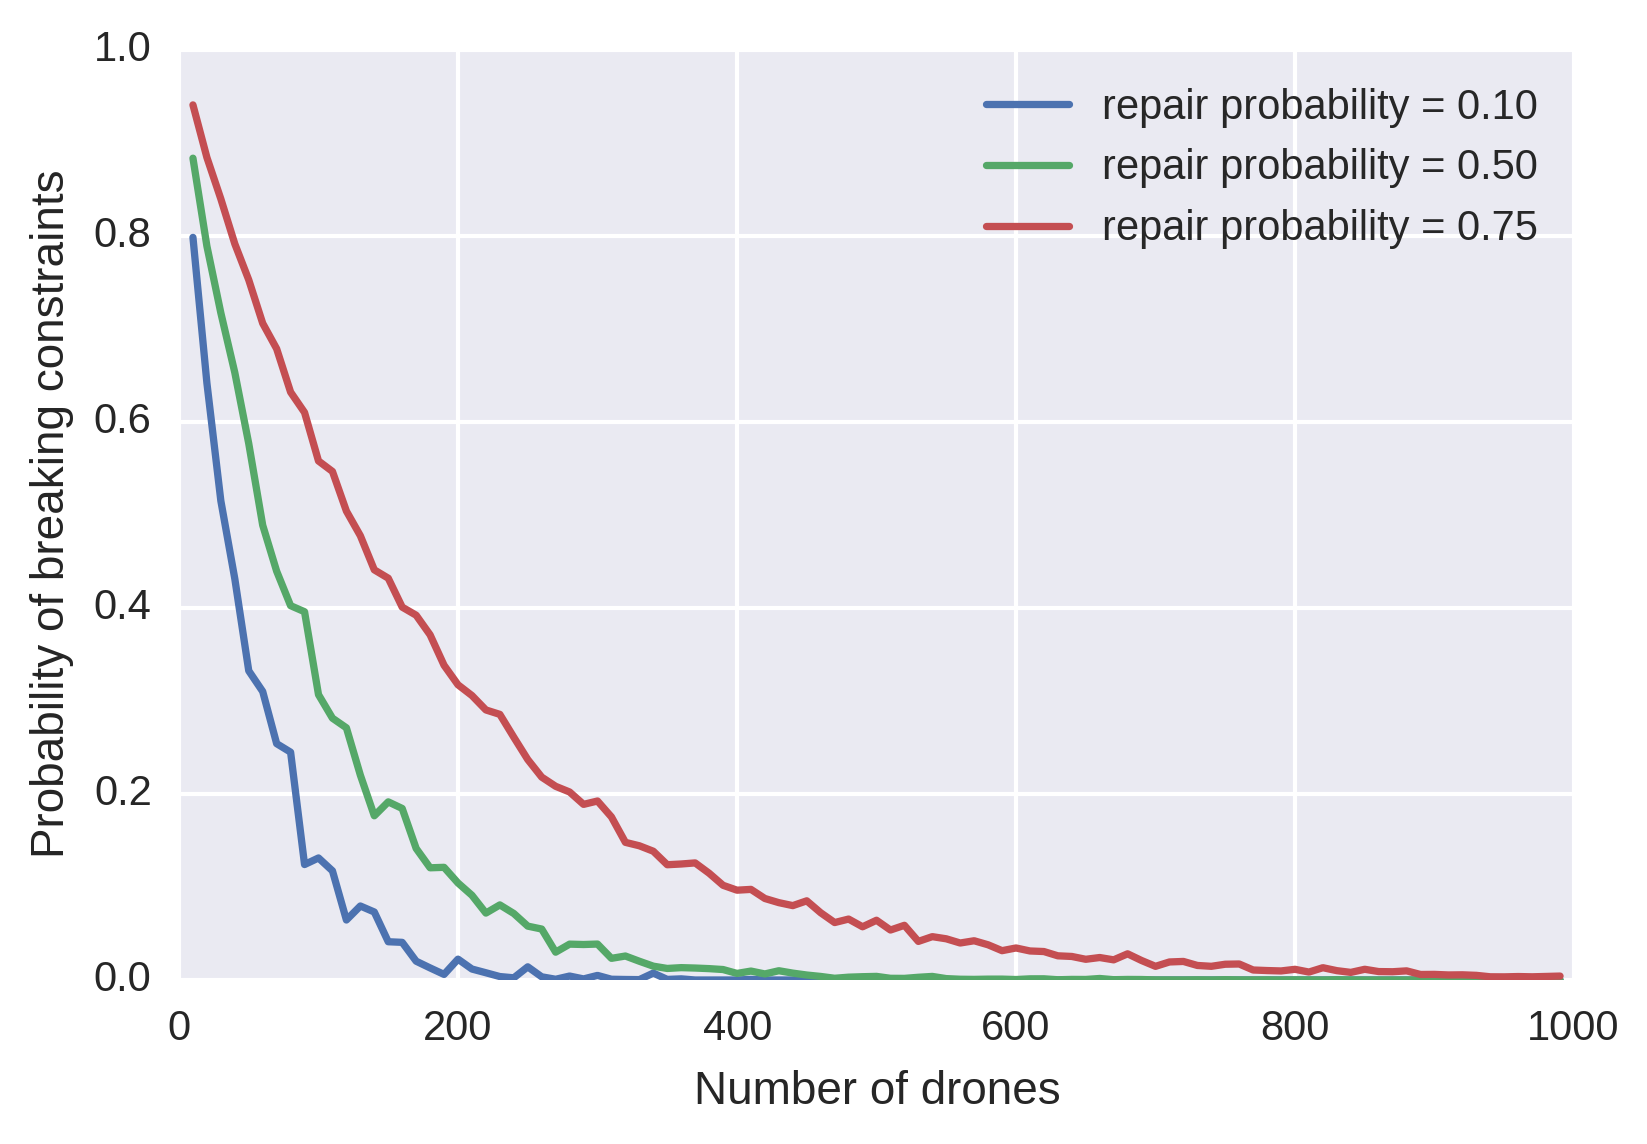

In [17]:
plt.xlabel('Number of drones')
plt.ylabel('Probability of breaking constraints')
for rp, ys_of_rp in zip(repair_probabilities, ys):
    plt.plot(xs, ys_of_rp, label='repair probability = %0.2f' % rp)
plt.legend(loc='best')
plt.savefig('part2b.pdf', dpi=300)
plt.show()

##Part 3

In [18]:
low_priority_areas = [88] # blocks^2
medium_priority_areas = [56, 80, 136, 600, 600] # blocks^2
high_priority_areas = [16, 24] # blocks^2

In [19]:
areas = low_priority_areas + medium_priority_areas + high_priority_areas
priority_freqs = ([low_priority_freq] * len(low_priority_areas)) + ([medium_priority_freq] * len(medium_priority_areas)) + ([high_priority_freq] * len(high_priority_areas))

In [20]:
print sum(n_min(freq, area) for area, freq in zip(areas, priority_freqs))

52.0


In [21]:
assert all((simulate_surveillance(n_min(freq, area), area) < 1 / freq).all() for area, freq in zip(areas, priority_freqs))
print "Tests passed"

Tests passed


/home/chris/.anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


##Part 4

In [22]:
def prob_freq_constraint_broken(num_drones):
    times_since_last_observation = simulate_surveillance(num_drones, city_area, uniform_init=False, rand_dirs=True)
    return np.mean(times_since_last_observation > 1 / medium_priority_freq)

In [23]:
xs = np.arange(10, 1000, 10)
ys = [prob_freq_constraint_broken(x) for x in xs]

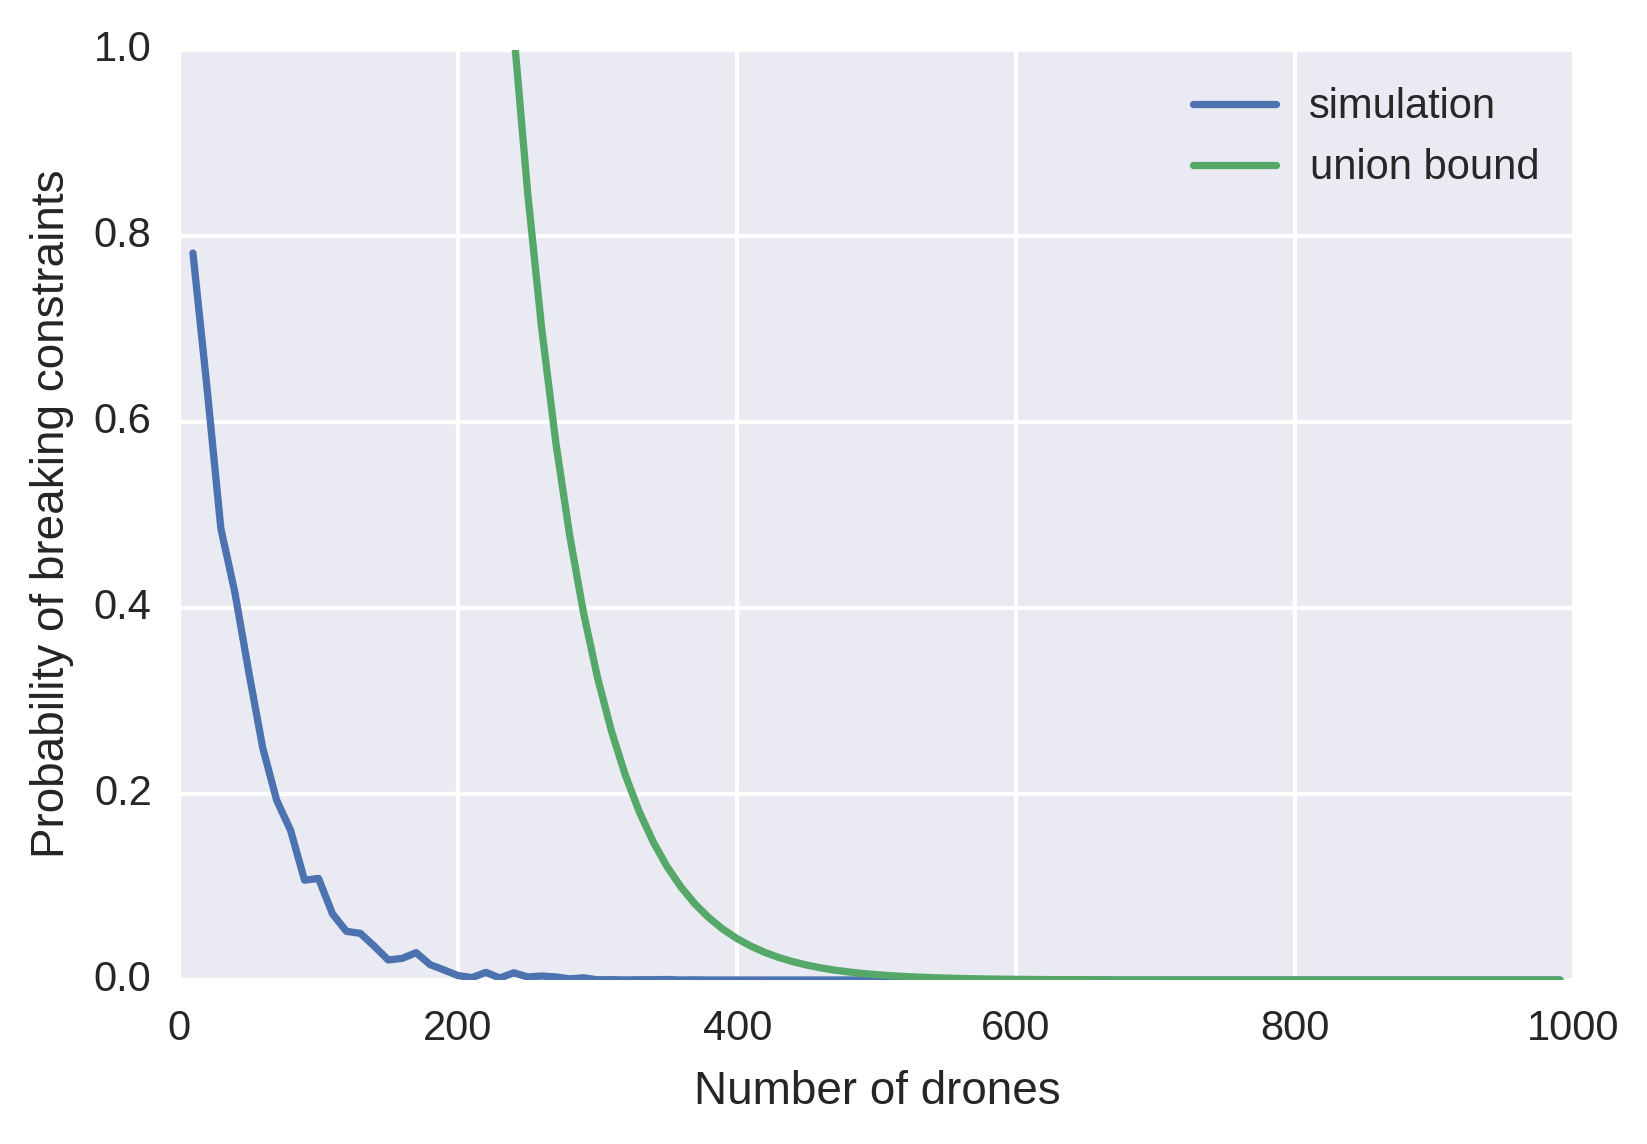

In [24]:
plt.xlabel('Number of drones')
plt.ylabel('Probability of breaking constraints')
plt.plot(xs, ys, label='simulation')
plt.plot(xs, xs*(1 - drone_speed / (medium_priority_freq * cell_dist * city_area))**xs, label='union bound')
plt.ylim([0, 1])
plt.legend(loc='best')
plt.savefig('part4.pdf', dpi=300)
plt.show()